In [16]:
import requests
import pandas as pd
from datetime import datetime

# Define Jaeger API URL
JAEGER_API_URL = "http://192.168.227.176:16686/api/traces" # socail-network in default namesapce

# Define parameters for the query
service_name = "nginx-web-server"
lookback = "10m"
limit = 1500

# Function to query Jaeger API
def query_jaeger(service_name, lookback, limit):
    params = {
        "service": service_name,
        "lookback": lookback,
        "limit": limit
    }
    response = requests.get(JAEGER_API_URL, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse tags and logs into a dictionary
def parse_tags_logs(tags, logs):
    tag_dict = {tag['key']: tag['value'] for tag in tags}
    log_list = [{'timestamp': log['timestamp'], **{field['key']: field['value'] for field in log['fields']}} for log in logs]
    return tag_dict, log_list

# Parse the trace data
def parse_jaeger_data(data):
    traces = data['data']
    trace_list = []
    for trace in traces:
        trace_id = trace['traceID']
        for span in trace['spans']:
            span_id = span['spanID']
            parent_span_id = span['references'][0]['spanID'] if span['references'] else None
            operation = span['operationName']
            service_name = span['process']['serviceName'] if 'process' in span and 'serviceName' in span['process'] else 'unknown'
            start_time = datetime.utcfromtimestamp(span['startTime'] / 1e6)
            duration = span['duration'] / 1e3  # Convert microseconds to milliseconds
            tags, logs = parse_tags_logs(span['tags'], span['logs'])
            trace_list.append({
                "trace_id": trace_id,
                "span_id": span_id,
                "parent_span_id": parent_span_id,
                "operation": operation,
                "service_name": service_name,
                "start_time": start_time,
                "duration": duration,
                "tags": tags,
                "logs": logs
            })
    return pd.DataFrame(trace_list)

# Fetch trace data from Jaeger
data = query_jaeger(service_name, lookback, limit)

# Parse the data into a DataFrame
df = parse_jaeger_data(data)

# Convert 'start_time' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])

# Save DataFrame to CSV
df.to_csv('k8s_composePost.csv', index=False)



In [17]:

df


,trace_id,span_id,parent_span_id,operation,service_name,start_time,duration,tags,logs
0,170159f4fd867a50,542f2081de65845c,8c7da8e536d62f7a,read_home_timeline_client,unknown,2024-06-30 13:13:50.483635,67.902,{'internal.span.format': 'proto'},[]
1,170159f4fd867a50,8c7da8e536d62f7a,170159f4fd867a50,/wrk2-api/home-timeline/read,unknown,2024-06-30 13:13:50.483607,67.960,"{'component': 'nginx', 'nginx.worker_pid': '10...",[]
2,170159f4fd867a50,170159f4fd867a50,None,/wrk2-api/home-timeline/read,unknown,2024-06-30 13:13:50.483000,68.568,"{'sampler.type': 'probabilistic', 'sampler.par...",[]
3,170159f4fd867a50,e9659e79bacf9ef4,fe160c0be6427142,post_storage_read_posts_server,unknown,2024-06-30 13:13:50.532453,0.003,{'internal.span.format': 'proto'},[]
4,170159f4fd867a50,4605a7befd872b46,fe160c0be6427142,read_home_timeline_redis_find_client,unknown,2024-06-30 13:13:50.483871,48.426,{'internal.span.format': 'proto'},[]
...,...,...,...,...,...,...,...,...,...
25217,12c95ed2b741f257,b1f11e445375401d,08d39534129ab6a8,compose_user_mentions_memcached_get_client,unknown,2024-06-30 13:16:27.782077,166.146,{'internal.span.format': 'proto'},[]
25218,12c95ed2b741f257,52f919a8b35d427d,08d39534129ab6a8,compose_user_mentions_mongo_find_client,unknown,2024-06-30 13:16:27.948240,57.228,{'internal.span.format': 'proto'},[]
25219,12c95ed2b741f257,08d39534129ab6a8,be9a645a439917fd,compose_user_mentions_server,unknown,2024-06-30 13:16:27.782069,223.408,{'internal.span.format': 'proto'},[]
25220,12c95ed2b741f257,cce3e4152651e186,16647ff20471c42f,post_storage_mongo_insert_client,unknown,2024-06-30 13:16:28.021781,0.864,{'internal.span.format': 'proto'},[]


Total Spans: 9000
Error Spans: 0
Error Rate: 0.00%


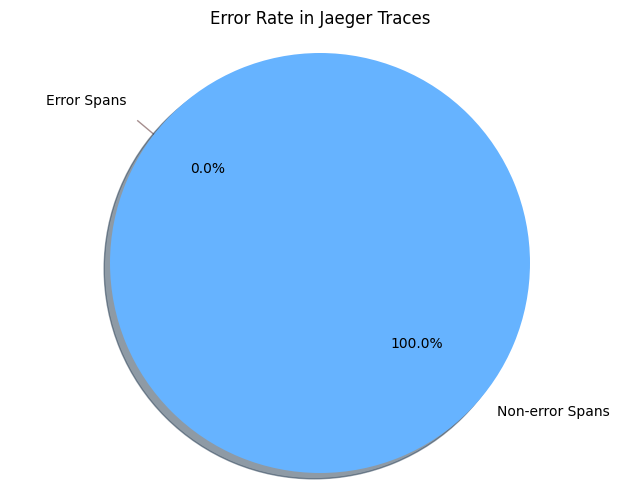

In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the Jaeger trace data from CSV
df = pd.read_csv('k8s_composePost.csv')

# Function to check if a span contains an error
def contains_error(tags):
    try:
        # Convert string representation of dictionary to actual dictionary
        tags_dict = json.loads(tags.replace("'", '"'))
        # Check for common error indicators
        return 'error' in tags_dict or ('http.status_code' in tags_dict and int(tags_dict['http.status_code']) >= 400)
    except (json.JSONDecodeError, ValueError, TypeError):
        # Return False if there is an issue with decoding or if tags are not in the expected format
        return False

# Identify error spans
df['is_error'] = df['tags'].apply(contains_error)

# Calculate error rate
total_spans = len(df)
error_spans = df['is_error'].sum()
error_rate = error_spans / total_spans

# Print error rate
print(f'Total Spans: {total_spans}')
print(f'Error Spans: {error_spans}')
print(f'Error Rate: {error_rate:.2%}')

# Visualize the error rate
labels = ['Error Spans', 'Non-error Spans']
sizes = [error_spans, total_spans - error_spans]
colors = ['#ff6666', '#66b3ff']
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Error Rate in Jaeger Traces')
plt.show()
